## Задача: Поиск фейковых отзывов
Отзывы на Wildberries — вид обратной связи, которую можно оставить только после заказа товара. Отзывы отображаются в карточке товара и отражаются в виде рейтинга товара в звездах с текстовым комментарием.
 
#### Задача
Необходимо разработать механизм, позволяющий определить фейковые отзывы. Фейковый отзыв — проплаченный, нечестно мотивированный отзыв с целью повлиять на рейтинг товара. 
Существует два вида таких отзывов: 
* положительный отзыв написан для поставщика, который заказал себе этот отзыв; 
* отрицательный отзыв написан для другого поставщика с целью снизить рейтинг товара.

#### Данные
Предоставляем список размеченных отзывов, со всей необходимой мета-информацией формате csv (пользователь, текст отзыва, оценка, является ли фейком)
Результат
Итогом работы должен стать набор скриптов, который позволяет по полученному на входе отзыву получить ответ, является отзыв фейковым, а также сформированная выдача для тестовых отзывов.

#### Этапы разработки решения
* --> L0 - Проработка и формализация задачи, определение таргета	определен таргет, определена мл задача (2 недели)
* L1 - Первичный анализ данных, очищение данных	проведен EDA, данные изучены, убраны все выбросы, пропуски и лишние данные (1 неделя)
* L2 - Ресерч проблематики, определение набора подходящих решений	проведен поиск решений среди научных работ/статей, отобраны наиболее оптимальные решения и сформирована итоговая архитектура решения (1 неделя)	
* L3 - Формирование обучающей выборки, проектирование валидации	сформирована обучающая, тестовая и валидационная выборки, построен пайплайн валидации (1 неделя)
* L4 - Разработка бейзлайна и реализация выбранного решения	готов бейзлайн и первая реализация выбранного решения (2 недели)
* L5 - Оценка решения, оптимизация алгоритма	проведен анализ оптимальной метрики для оценки решения, проведена оценка бейзлайна и целевого решения, подобраны параметры решения улучшающие метрики (1 неделя)
* L6 - Приведение решения в читабельный вид (аналог вывода в продакшн) улучшена структура кода, написаны комментарии (1 неделя)




In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
from multiprocessing import Pool
from tqdm import tqdm

In [146]:
df = pd.read_csv("wb_school_task_2.csv")
df

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.000000,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.700000,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.000000,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.000000,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.000000,6,4,5.000000,26,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",2,2,3.000000,19,1,4.263158,9,9,0
3119,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",8,8,4.375000,131,83,4.183206,18,18,0
3120,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",13,12,5.000000,145,2,4.944828,12,14,0
3121,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",3,3,5.000000,205,19,4.648780,103,155,0


In [147]:
# проверим на пропуски
df.isna().mean()

id1      0.0
id2      0.0
id3      0.0
text     0.0
f1       0.0
f2       0.0
f3       0.0
f4       0.0
f5       0.0
f6       0.0
f7       0.0
f8       0.0
label    0.0
dtype: float64

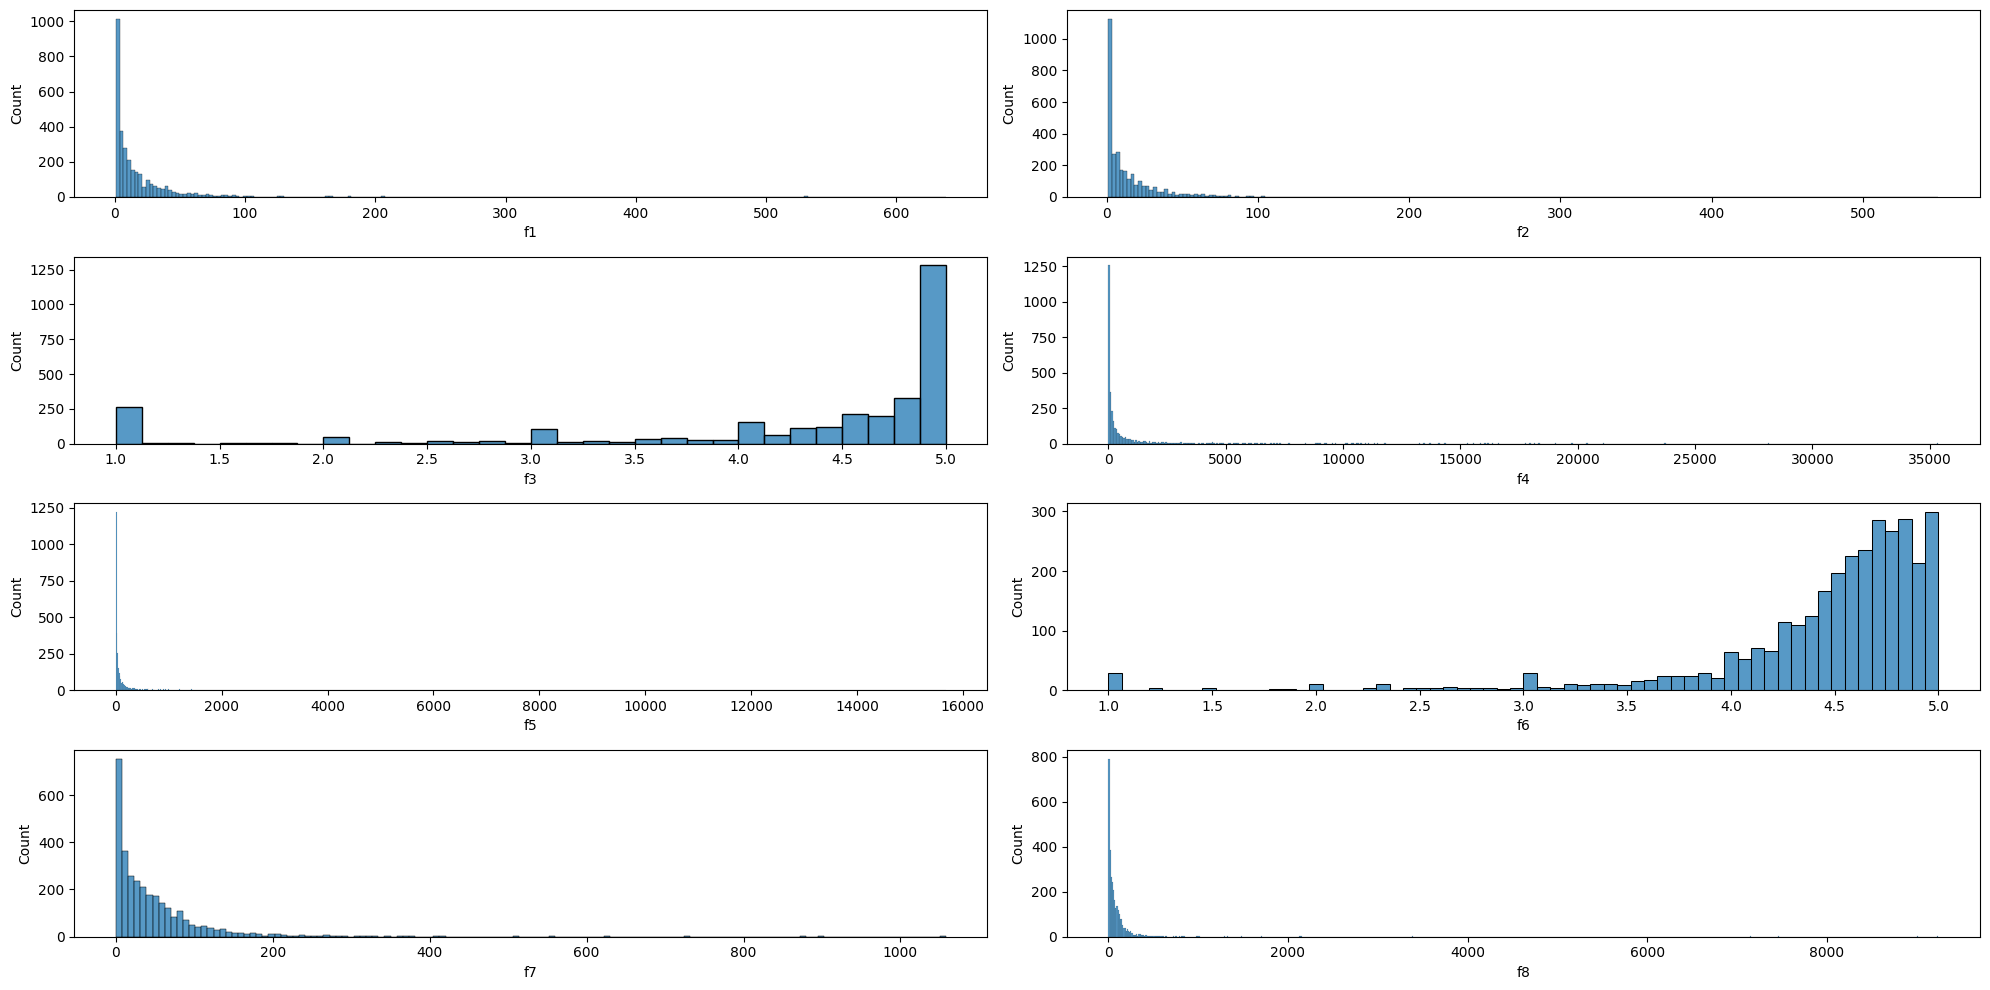

In [148]:
fig, axes = plt.subplots(4, 2, figsize=(20, 10))
sns.histplot(data=df.f1, ax=axes[0,0])
sns.histplot(data=df.f2, ax=axes[0,1])
sns.histplot(data=df.f3, ax=axes[1,0])
sns.histplot(data=df.f4, ax=axes[1,1])
sns.histplot(data=df.f5, ax=axes[2,0])
sns.histplot(data=df.f6, ax=axes[2,1])
sns.histplot(data=df.f7, ax=axes[3,0])
sns.histplot(data=df.f8, ax=axes[3,1])
plt.xticks()
plt.tight_layout()
plt.show()

Распределения признаков имеют очень длинные хвосты, поэтому заведем их в логарифмированном виде

In [149]:
np.seterr(divide = 'ignore') 
df['log_f1'] = np.log(df['f1'])
df['log_f2'] = np.log(df['f2'])
df['log_f4'] = np.log(df['f4'])
df['log_f5'] = np.log(df['f5'])
df['log_f7'] = np.log(df['f7'])
df['log_f8'] = np.log(df['f8'])

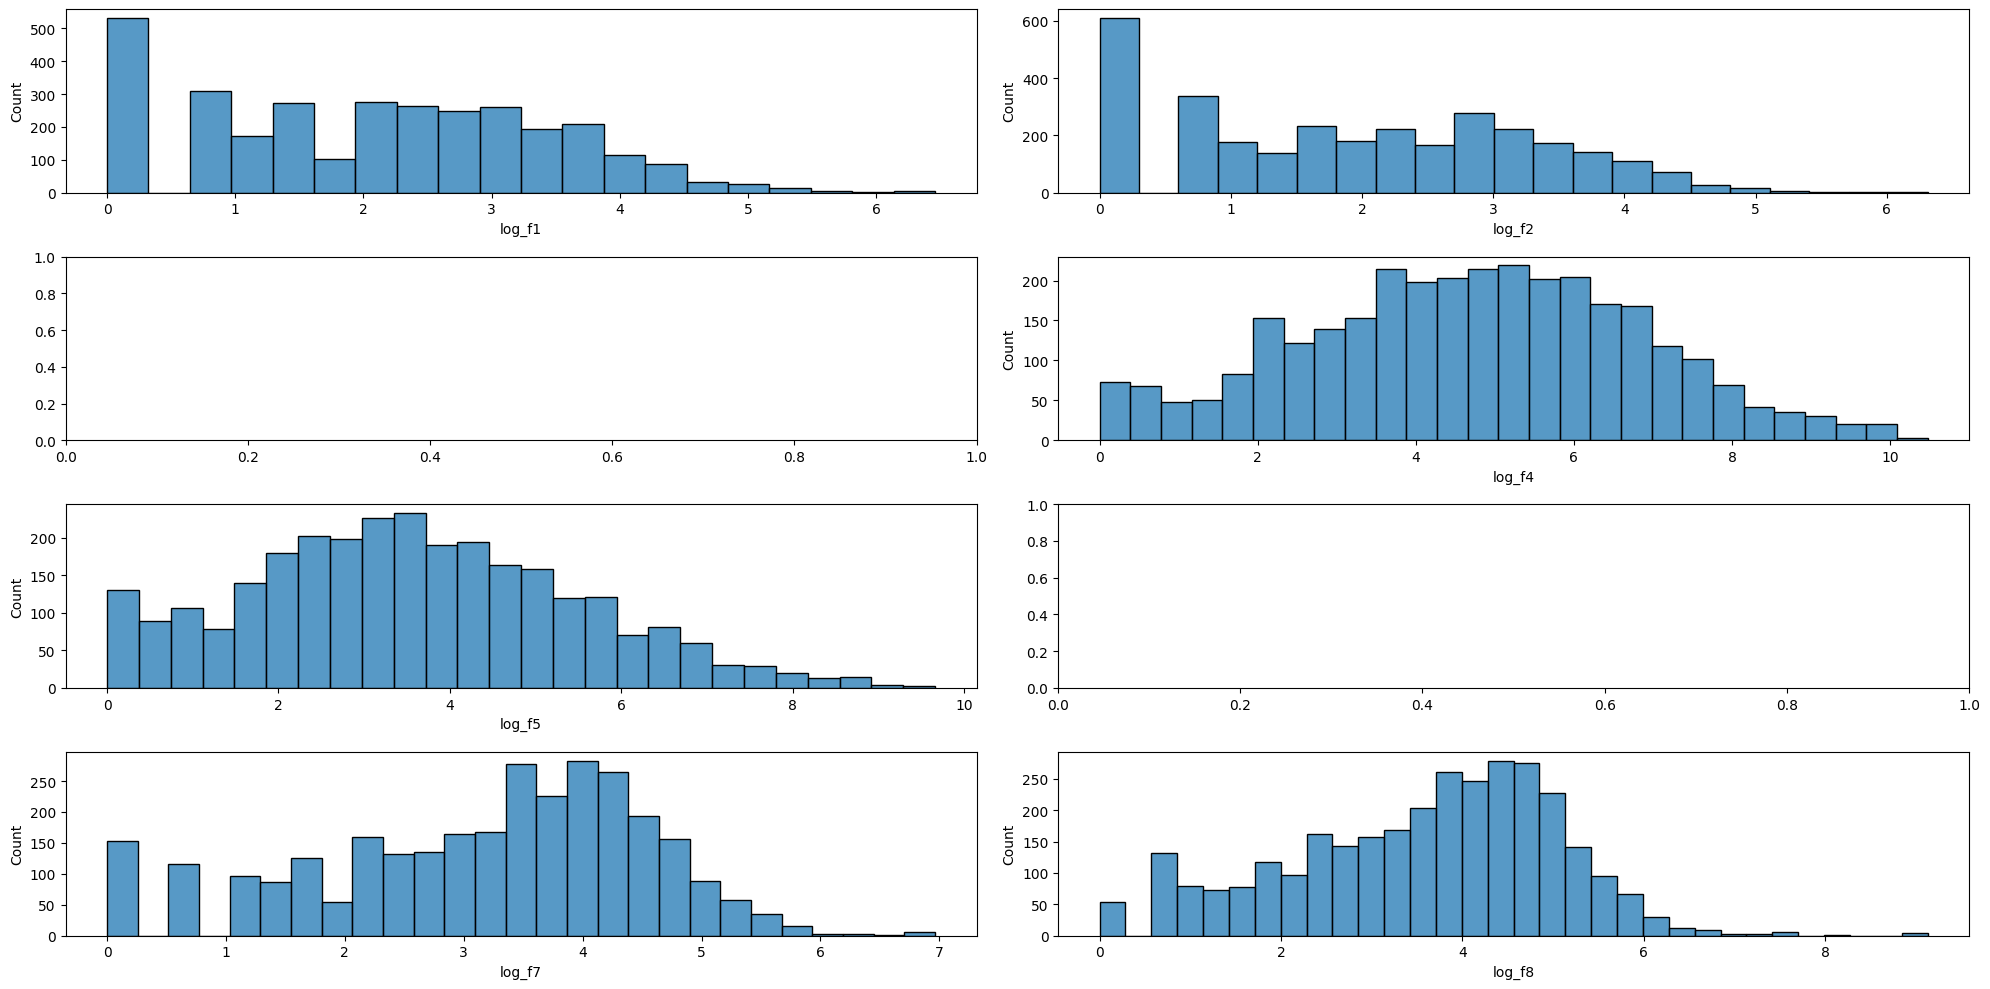

In [150]:
fig, axes = plt.subplots(4, 2, figsize=(20, 10))
sns.histplot(data=df.log_f1, ax=axes[0,0])
sns.histplot(data=df.log_f2, ax=axes[0,1])
sns.histplot(data=df.log_f4, ax=axes[1,1])
sns.histplot(data=df.log_f5, ax=axes[2,0])
sns.histplot(data=df.log_f7, ax=axes[3,0])
sns.histplot(data=df.log_f8, ax=axes[3,1])
plt.xticks()
plt.tight_layout()
plt.show()

In [154]:
df.text

0       Хотела купить на замену старых,по итогу эти  у...
1       Запах по сравнению с обычным DOVE никакой. Оно...
2                        Кабель подошёл, хорошо работает.
3       Восторг! Очень приятный аромат, держится долго...
4       Визуально все хорошо. Не пробовали. Купили в п...
                              ...                        
3118    Стекло не плохое,но есть один минус на техно с...
3119    Всё пришло запаковано, ничего не сломано. Лучш...
3120    Мне нравятся 👍🏻 я очень аллергичная, посоветов...
3121             Спасибо,  целая пришла. Хорошо упаковано
3122              Бур нормальный, но выбрал другую модель
Name: text, Length: 3123, dtype: object

In [175]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian') 

def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [176]:
lemmas = list(tqdm(map(clean_text, df['text']), total=len(df)))
df['lemmas'] = lemmas

100%|██████████████████████████████████████| 3123/3123 [00:11<00:00, 268.82it/s]


In [177]:
df['lemmas'].sample(5)

1685                    далее шевый сердито рекомендовать
3043    щенок алабай понравиться неделя пока живой еди...
2126                         классный ручка рекомендовать
2173    кривая самый обидный взять фотосъёмка начать н...
28                                    отличный лофер цена
Name: lemmas, dtype: object